<a href="https://colab.research.google.com/github/hannape/CNN-second/blob/master/001_SplitRecordingAsFunction_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## JAKO FUNKCJA

!pip install audiosegment
!pip install librosa
!pip install pydub
!pip install webrtcvad
!pip install librosa
!pip install -q spectrum
!pip install pkgconfig libtfr


In [0]:
import libtfr
import librosa
from scipy.io import wavfile
from random import choice
import librosa
from pydub import AudioSegment
from pydub.utils import make_chunks
import math
import audiosegment
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import glob
import os
import scipy
import librosa
from librosa import display
from librosa.core import power_to_db
from librosa.core import amplitude_to_db
import IPython.display as ipd

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#wav_file_size = (sample_rate * bit_rate * channel_count * duration_in_ms / 1000) / 8

#### Parametry ####
             
plot_repr = 0          # czy wyrysowywać głosy wszystkie
play_sound = 0
minimal_duration = 4   # minimalny czas trwania głosu w ms, b zakwalifikowac chunka jako hasbird
f_min = 4000           # minimalna częstotliwość analizowana ze spektro
f_max = 9500           # maksymalna częstotliwość analizowana ze spektro
f_min2 = 4000           # minimalna częstotliwość analizowana ze spektro
f_max2 = 9500           # maksymalna częstotliwość analizowana ze spektro
n_mels = 60
n_mels2 = 80
step = 150

###################

def get_logmelspec_settings():
    logmelspec_settings = {
        "fmin": 4000, #2000
        "fmax": 9500, #11025,
        "hop_length": 200, #150,#32,
        "n_fft": 512, #1024, 
        "n_mels": 60, #128,
        "sr": 44100, #22050,
        "win_length": 512, #256,
        "window": "hann"}
    return logmelspec_settings
  
def get_spec_settings():
    logspec_settings = {
        "fmin": 4000, #2000
        "fmax": 9500, #11025,
        "hop_length": 150,#32,
        "n_fft": 512, #1024, 
        "n_mels": 60, #128,
        "sr": 44100, #22050,
        "win_length": 512, #256,
        "window": "hann"}  ## hann
    return logspec_settings  

def representations(frame):
  
      ####### reprezentacja 1 - spektrogram
      global result1, result2, result3, result4, result5, ukybirddet_spectrogram, samples_float,stft1, stft2, stft3
      
      fs = 44100
      samples = frame.get_array_of_samples()
      samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
      audio = np.array(samples_float)
      
      logspec_settings = get_spec_settings()
      stft = librosa.stft(
          audio,
          n_fft=logspec_settings["n_fft"],
          win_length=logspec_settings["win_length"],
          hop_length=logspec_settings["hop_length"],
          window= logspec_settings["window"] ) #scipy.signal.get_window(('gaussian',50) ,512) )#scipy.signal.gaussian(512, 2)   ) 
      stft1 = amplitude_to_db(np.abs(stft)**2)
      freqs = librosa.core.fft_frequencies(n_fft=logspec_settings["n_fft"], sr=44100)
      fmin =  min(freqs[(freqs >= f_min)])
      i,  = np.where( freqs >= min(freqs[(freqs >= f_min)]))
      j,  = np.where( freqs <= max(freqs[(freqs <= f_max)]))
      #print(np.shape(stft1),min(i),max(j))
      stft1 = stft1[min(i):max(j),]
      #print(np.shape(stft1))
      result1 = stft1
      
      ####### reprezentacja 2 - spektro z inną rozdzielczością, naśladujące bulbula ?
      
      waveform = librosa.resample(np.array(samples_float), 44100, 22050)
      stft2 = librosa.stft(
          waveform,
          n_fft=1024,
          win_length=1024,
          hop_length=315,
          window=logspec_settings["window"]) 
      stft2 = amplitude_to_db(np.abs(stft2)**2)  
      freqs2 = librosa.core.fft_frequencies(n_fft=1024, sr=22050)
      i,  = np.where( freqs2 >= min(freqs2[(freqs2 >= 50)]))
      j,  = np.where( freqs2 <= max(freqs2[(freqs2 <= 11000)]))
      #print(np.shape(stft2),min(i),max(j))
      stft2 = stft2[min(i):max(j),]
      result2 = stft2

      ####### reprezentacja 3 - mel spektrogram, pipeline z birdvoxa
      ##  logmelspec_settings = {"fmin": 2000,"fmax": 11025,"hop_length": 32,"n_fft": 1024,
      ##  "n_mels": 128, "sr": 22050, "win_length": 256, "window": "hann"} za https://github.com/BirdVox/bv_context_adaptation/blob/master/src/localmodule.py
      
      logmelspec_settings = get_logmelspec_settings()

      # Compute Short-Term Fourier Transform (STFT).
      stft = librosa.stft(
          np.array(samples_float),
          n_fft=logmelspec_settings["n_fft"],
          win_length=logmelspec_settings["win_length"],
          hop_length=logmelspec_settings["hop_length"],
          window=logmelspec_settings["window"])

      # Compute squared magnitude coefficients.
      abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)
      abs3_stft = np.abs(stft)**2

      # Gather frequency bins according to the Mel scale.
      melspec = librosa.feature.melspectrogram(
          y=None,
          S=abs2_stft,
          sr=logmelspec_settings["sr"],
          n_fft=logmelspec_settings["n_fft"],
          n_mels=logmelspec_settings["n_mels"],
          htk=True,
          fmin=logmelspec_settings["fmin"],
          fmax=logmelspec_settings["fmax"])     
      
      # Apply pointwise base-10 logarithm.
      logmelspec = 0.5 * librosa.amplitude_to_db(melspec, ref=1.0)

      # Convert to single floating-point precision.
      logmelspec = logmelspec.astype('float32')
      result3 = logmelspec
      
      ## przerzucenie typu danych z audioframe na próbki, czy ok? nie wiem
      samples = frame.get_array_of_samples()
      samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
      
      
      
      #result3 = librosa.feature.melspectrogram(y=samples_float, sr=44100, n_mels= n_mels, fmin = 4000, fmax=9500)
            
      ####### reprezentacja 4 - mel spektrogram mniej filtrów
      result4 = librosa.feature.melspectrogram(y=None, S=abs2_stft, sr=44100, n_mels= 45, fmin = 4000, fmax=9500, hop_length=512, n_fft=512)
      result4 = 0.5 * librosa.amplitude_to_db(result4, ref=1.0)
      
      ####### reprezentacja 5 - multitaper
      
      #result5 = libtfr.tfr_spec(samples_float, N = 512, step = 30, Np = 512, K =6, tm =6, flock =0.1, tlock = 5)
      #plt.imshow(S, cmap="jet")
      result5 = libtfr.tfr_spec(audio, N = 512, step = 355, Np = 512, K = 2, tm = 1, flock =0.1, tlock = 10)
      freqs, ind = libtfr.fgrid(fs, 512, fpass=(4000,9500)) 
      result5 = result5[ind,]; # tylko interesujące nas pasmo
      
      
      ####### reprezentacja 6 - preprocessing bulbul/ukybirdet, zaimplementowałam jak umiałam, nie do końca jasno napisane
      #audio = librosa.load(samples_float, sr = 44100)[0]
      audio = librosa.resample(samples_float, 44100, 22050)
      my_stft = librosa.core.stft(audio, n_fft=1024, hop_length=315, window='hann')
      D = np.abs(my_stft)**2
      my_melspect = librosa.feature.melspectrogram(S=D, n_mels= n_mels, fmin = f_min, fmax= f_max)
      my_melspect1 = librosa.power_to_db(my_melspect)
      stand_spectrogram = preprocessing.scale(my_melspect1, axis=1)
      no_noise_spectrogram = (stand_spectrogram.transpose() - (np.mean(stand_spectrogram,axis=1))).transpose()
      ukybirddet_spectrogram = librosa.power_to_db(preprocessing.normalize(my_melspect,axis=1))
      
      ####### reprezentacja 7 - transformata gabora - taki spektrogram z oknem gaussa?
      
      samples = frame.get_array_of_samples()
      samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
      audio = np.array(samples_float)
      
      logspec_settings = get_spec_settings()
      stft3 = librosa.stft(
          audio,
          n_fft=logspec_settings["n_fft"],
          win_length=logspec_settings["win_length"],
          hop_length=logspec_settings["hop_length"],
          window= scipy.signal.get_window(('gaussian',200) ,logspec_settings["n_fft"]) )
      stft3 = amplitude_to_db(np.abs(stft3)**2)
      freqs = librosa.core.fft_frequencies(n_fft=logspec_settings["n_fft"], sr=44100)
      fmin =  min(freqs[(freqs >= f_min)])
      i,  = np.where( freqs >= min(freqs[(freqs >= f_min)]))
      j,  = np.where( freqs <= max(freqs[(freqs <= f_max)]))
      #print(np.shape(stft3),min(i),max(j))
      stft3 = stft3[min(i):max(j),]
      #print(np.shape(stft3))
  
      
      ####### reprezentacja 8 def get_pcen_settings(): pcen_settings = { "fmin": 2000,"fmax": 11025,"hop_length": 32,
      ## "n_fft": 1024,"n_mels": 128,"pcen_delta_denominator": 10,"pcen_time_constant_frames": 40,"pcen_norm_exponent": -0.8,
      ## "pcen_power": 0.25,"sr": 22050,"win_length": 256,"window": "hann"} return pcen_settings
      ####### reprezentacja 9: falki?
      
      #librosa.display.specshow(result5,cmap="jet", x_axis='time')      
      
      if plot_repr == 1:
   
        plt.subplot(421)
        librosa.display.specshow(result1, cmap="jet", sr=44100)
        #plt.imshow(result3, cmap="jet")
        plt.title('Spect1')
        
        plt.subplot(422)
        librosa.display.specshow(result2, cmap="jet", sr=22050)
        #plt.imshow(result3, cmap="jet")
        plt.title('Spect2 bulbul')

        plt.subplot(423)
        librosa.display.specshow(result3,y_axis='mel',fmin = f_min, fmax = f_max, cmap="jet")
        #plt.imshow(result3, cmap="jet")
        plt.title('Melspect1')
        #plt.colorbar(format='%+2.0f dB')
        
        plt.subplot(424)
        librosa.display.specshow(result4,y_axis='mel',fmin = f_min, fmax = f_max, cmap="jet")
        plt.title('Melspect2')
        #plt.colorbar(format='%+2.0f dB')
        
        plt.subplot(425)
        librosa.display.specshow(result5,cmap="jet", x_axis='time')
        #librosa.display.specshow(result5[40:90],x_axis='time')
        #plt.imshow(result5, cmap="jet")
        plt.title('Multitaper')
                
        plt.subplot(426)             
        librosa.display.specshow(ukybirddet_spectrogram, x_axis='time')
        #plt.colorbar()#format='%+2.0f dB')
        plt.title('Log-Power spectrogram ukybirddet')
 
        plt.subplot(427)             
        librosa.display.specshow(stft3, cmap="jet", sr=44100)
        plt.title('Gabor transform?')
        plt.show()
 
      if play_sound ==1:
        
        ipd.Audio(samples_float,rate=44100)      

In [0]:


def SplitRecordingFunctionTest(nazwa):

  name = nazwa + ".wav"
  name_txt = nazwa + ".txt" #dot.txt"  txt przecinkowe

  with open((source_labels + name_txt), 'r+') as f:  # zmiana na kropki
      text = f.read()
      f.seek(0)
      f.truncate()
      f.write(text.replace(',', '.'))
  fs, data = wavfile.read(source + name)   # wypluwa błąd, nie rozumie opisow dodanych przez Audacity pewnie
  print(name)
  print(source_labels + name_txt)
  myaudio = audiosegment.from_file(source + name)
  channel_count = myaudio.channels    #Get channels
  sample_width = myaudio.sample_width #Get sample width
  duration_in_ms = len(myaudio) #Length of audio in ms
  sample_rate = myaudio.frame_rate
  nr_of_chunks =  1 + (duration_in_ms - chunk_length_ms) / (chunk_length_ms - chunk_overlap)
  print(nr_of_chunks)

  ########## Odczyt labeli z csv, wyczyszczenie zaznaczonych trzasków (t, ?)
  calls_to_cut = ['t', 't?', 'g', 'czapla', 'gh', 'g cz', 'puszczyk']
  if (os.stat(source_labels + name_txt).st_size != 0):
    y_read = pd.read_csv(source_labels + name_txt,  header=None, sep = "\t")
    y_read.columns = ["start", "end", "bird"]
    #print(if y_read['bird'] not in ['g' 't']: print y_read['bird'] )
    y_read_cleaned = y_read[~y_read['bird'].isin(calls_to_cut)]
    #y_read_cleaned = y_read[y_read['bird']!= 'g']#any('t' 't?' 'g' 'czapla' 'gh' 'g cz' 'puszczyk')]  # deleted 't'
    #y_read_cleaned = y_read[if y_read['bird'] not in any('t' 't?')]  # deleted 't'
    #any(if y_read['bird'] not in any('g' 't?'))
    #y_read_cleaned = y_read_cleanedA[y_read_cleanedA['bird']!= 't?'] # deleted 't?'
    print(y_read_cleaned['bird'])
    y_read = y_read_cleaned
    not_empty = 1
  else:
    print(source_labels + name_txt)
    print("bez etykiet!!! : " + str(name))
    not_empty = 0
    sum_birds2 = 0
    y_read=[]
    birds_chunks = []
    df=pd.DataFrame()
  
  ##do usunięcia jeszcze g - niższe głosy, p - puszczyk, g cz, cz - czapla, gaski, gh  
  
  ########## Wyszukanie pozytywnych fragmentów - fragmentów zawierający głos, ilość takich ramek
  
  
  image_positive = []
  description_positive = []
  species=[]
  sum_birds=0
  has_bird = 1
  plot_repr = 0          # czy wyrysowywać głosy wszystkie
  play_sound = 1
  rep1 = []
  rep2 = []
  rep3 = []
  rep4 = []
  rep5 = []
  rep6 = []
  rep7 = []
  hasbird =[]
  spec= []
  labels = ['Chunk_nr', 'Chunk_start', 'Chunk_end', 'Call_start_chunk','Call_end_chunk','Call_start','Call_end','Has_bird','2nd_call_start','2nd_call_end']

  '''
  if (not_empty):
    for i in range(0,math.floor(nr_of_chunks)): #(2300,2600): #math.floor(nr_of_chunks)): 
      frame_start = i*(chunk_length_ms - chunk_overlap)
      frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
      frame = myaudio[frame_start : frame_end]
      x = range(frame_start,frame_end)

      #if (y_read !=)
      for j in y_read.index.tolist():
        bird_start = int(round(y_read.start[j]*1000))
        bird_end = int(round(y_read.end[j]*1000))
        y = range(bird_start,bird_end)

        intersect_start = max(x[0], y[0])
        intersect_end = min(x[-1], y[-1])+1
        range1 = (range(intersect_start, intersect_end))

        if len(range1)> minimal_duration: 
          sum_birds = sum_birds+1

          representations(frame)  
          #image_positive.append(result1)  # nie musi być tutaj, dopiero po usunięciu duplikatów może?
          species.append(y_read.bird[j])
          hasbird.append([1])
          #description_positive.append([i, frame_start, frame_end, intersect_start, intersect_end, bird_start, bird_end, has_bird, 0, 0])
        
        
          

    print(species)
    print(hasbird)
    #ipd.Audio(samples_float,rate=44100)
    representations(frame)  # jeden przykładowy, ostatni,  by poznać wymiary reprezentacji       

    ########## Usunięcie duplikatów, zakładamy że nie więcej niż 2 głosy w ramce

    description_pd = pd.DataFrame.from_records(description_positive, columns=labels)   # na lepszy format

    duplic = description_pd[description_pd.duplicated(subset='Chunk_nr',keep=False)]   # wypisanie duplikujących sie ramek (ale z innym glosem zawartym)
    duplic_index = duplic.drop_duplicates(subset='Chunk_nr',keep='first')['Chunk_nr'].index.tolist() 

    #print(duplic)
    #print(duplic_index)

    df = description_pd.drop_duplicates(subset='Chunk_nr',keep='first')  # usuwamy drugie duplikaty z listy
    for i in duplic_index:
      df['2nd_call_start'][i]= description_pd['Call_start'][i+1]   # dopisujemy drugi głos do ramki
      df['2nd_call_end'][i]= description_pd['Call_end'][i+1]

    ########## Macierz wyjściowa obrazów i opisów, same ptaki

    #description_positive_no_duplic = df   # mamy opisy, czas na reprezentacje:


    for i in df.index: #range(0,np.shape(description_positive_no_duplic)[0]):
        frame = myaudio[df.Chunk_start[i]:df.Chunk_end[i]]
        representations(frame)
        rep1.append(result1)
        rep2.append(result2)
        rep3.append(result3)
        rep4.append(result4)
        rep5.append(result5)
        rep6.append(ukybirddet_spectrogram)
        spec.append(species[i])
    #print(np.shape(spec))  

    ########## Indexy pustych ramek
    #print((description_positive_no_duplic))
    
    sum_birds2 = np.shape(df)[0]  # bez powtórzeń już
    birds_chunks = df['Chunk_nr'].tolist()

  min_chunks = 50  # jeśli głosów w nagraniu jest mniej niż 50, to i tak dobierzemy 50 pustych fragmentów - by choć wziąć próbkę tych warunków
  if sum_birds2<min_chunks:
    sum_birds2 = min_chunks
  
  #print(sum_birds)
  import random
  random.seed(667)
  range_nonbirds = [i for i in range(0, math.floor(nr_of_chunks)) if i not in birds_chunks]
  nobirds_chunks = random.sample(range_nonbirds, sum_birds2)  # dobieramy tyle ramek bez ptaków, co mamy z ptakami. Losowo
  #print(nobirds_chunks)
  
  ########## Dodanie macierzy z ramkami bez ptaków
  description_negative = []
'''
  
  for i in range(0,math.floor(nr_of_chunks)):
    hadbird = 0;
    frame_start = i*(chunk_length_ms - chunk_overlap)
    frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
    frame = myaudio[frame_start : frame_end]
    representations(frame)
    rep1.append(result1)
    rep2.append(result2)
    rep3.append(result3)
    rep4.append(result4)
    rep5.append(result5)
    rep6.append(ukybirddet_spectrogram)
    rep7.append(stft3)
    x = range(frame_start,frame_end)

    if (len(y_read)!=0):
      for j in y_read.index.tolist():
          bird_start = int(round(y_read.start[j]*1000))
          bird_end = int(round(y_read.end[j]*1000))
          y = range(bird_start,bird_end)

          intersect_start = max(x[0], y[0])
          intersect_end = min(x[-1], y[-1])+1
          range1 = (range(intersect_start, intersect_end))

          if len(range1)> minimal_duration: 
            sum_birds = sum_birds+1
            hadbird=1
            representations(frame)  
            #image_positive.append(result1)  # nie musi być tutaj, dopiero po usunięciu duplikatów może?
            species.append(y_read.bird[j])
            hasbird.append([1])
            print(y_read.bird[j])

            #description_positive.append([i, frame_start, frame_end, intersect_start, intersect_end, bird_start, bird_end, has_bird, 0, 0])
          if (hadbird==1):
            break
       
    if (hadbird==0):
      species.append([0])
      hasbird.append([0])
      
    if (i%500==0):
      print("--- chunk nr %s recording %s---  " % (i, nazwa))
      print("--- %s seconds ---" % (time.time() - start_time))
      print(np.shape(rep1))  
      print(np.shape(species)) 
      print(np.shape(hasbird))  
      

      
      
  print(np.shape(rep1))  
  print(np.shape(species)) 
  print(np.shape(hasbird)) 
  
  ########## Złożenie dwóch macierzy i zapis
  #description_negative_pd = pd.DataFrame.from_records(description_negative, columns=labels)
  ######print(type(description_negative_pd))

  #####final_dataset = np.concatenate([image_positive_no_duplic, np.array(image_negative)])
  #final_description = pd.concat([df,description_negative_pd])

  #####np.save((source_out + nazwa + 'balanced_dataset' ),final_dataset)
  np.savez((source_out + nazwa + name_out ), rep1 = rep1, rep2 = rep2, rep3 = rep3, rep4 = rep4, rep5 = rep5, rep6 = rep6, rep7 = rep7, hasbird=hasbird, species = species) #  freqs=freqs, times= times,
  

In [0]:
#nazwa = nazwa_list[1]  # nagranie
#print(nazwa_list)
import time
################################################################ MAIN

source = "drive/My Drive/nagrania/2016/"
source_labels = "drive/My Drive/labele/2016/"
source_out = "drive/My Drive/repr7_2016/"
nazwa_list=[]
name_out = '_7rep'

a = os.listdir(source_labels)
for i in range(0,np.shape(a)[0]):
  nazwa_list.append(os.path.splitext(a[i])[0])
  print(os.path.splitext(a[i])[0])
  
#### Parametry ####
chunk_length_ms = 500
chunk_overlap = 150
bit_rate = 16
###################  

#nazwa = nazwa_list[1]  # nagranie
#print(nazwa)

for i in range(3,np.shape(nazwa_list)[0]):
  
  print("nagranie nr "+ str(i+1) + ": " + str(nazwa_list[i]))
  start_time = time.time()  
  SplitRecordingFunctionTest(nazwa_list[i])
  
  

  

In [6]:
source_repr = 'drive/My Drive/'
folder_main = [ 'repr7_2016/' ]
test_set = ['BUK4_20160922_005604_7rep.npz','BUK4_20161008_004605_7rep.npz', 'BUK4_20161016_012704_7rep.npz','BUK4_20161016_035704_7rep.npz', 'BUK5_20161101_002104a_7rep.npz', 'BUK5_20161101_002104b_7rep.npz' ]
repr_to_check = ['rep5'] #,'rep3', 'rep4', 'rep5'] #

for k in range(0, np.size(repr_to_check)):
  
  repr_nr = repr_to_check[k]
  print('-----------'+repr_nr+'-----------')
  
  # pierwsze dane, by mieć kształt macierzy i kolejno wcztywać następne
  records = os.listdir(source_repr + folder_main[0])
  records = [x for x in records if x in test_set]

  dane1 = np.load(source_repr + folder_main[0] + records[0],allow_pickle=True )
  X_test= dane1[repr_nr]
  y_test = dane1['hasbird']
  y_test_species = dane1['species'] 
  print(records[0])
  print(np.shape(X_test))
  print(np.shape(y_test))
  print(np.shape(y_test_species))
  print(np.shape(dane1['species']))
  print('Dostepne dane: ' + str(dane1.files))
  
  for i in range (1,np.size(records)):
    print(records[i])
    dane1 = np.load(source_repr + folder_main[0] + records[i], allow_pickle=True )
    X_test = np.concatenate((X_test,dane1[repr_nr]))
    y_test = np.concatenate((y_test,dane1['hasbird']))
    #print(np.shape(y_test_species))
    
    print(np.shape(X_test))
    print(np.shape(y_test))
    a = dane1['species']
    print(len(a.shape))
    if (len(a.shape)==2):  # jeśli dwa wymiary
       a = np.squeeze(dane1['species'])  # to squeezujemy
  
    y_test_species = np.concatenate((y_test_species,a )) 
    print(np.shape(y_test_species))
  
  
  print(np.shape(X_test))
  print(np.shape(y_test))
  print(np.shape(y_test_species))
  np.save(('drive/My Drive/X_test_' + repr_nr), X_test)
  
np.save(('drive/My Drive/y_test' ), y_test)
np.save(('drive/My Drive/y_test_species'), y_test_species)
#print(np.size(y_train))
 

-----------rep5-----------
BUK4_20161016_035704_7rep.npz
(5136, 64, 61)
(5136, 1)
(5136,)
(5136,)
Dostepne dane: ['rep1', 'rep2', 'rep3', 'rep4', 'rep5', 'rep6', 'rep7', 'hasbird', 'species']
BUK4_20161008_004605_7rep.npz
(10269, 64, 61)
(10269, 1)
1
(10269,)
BUK4_20161016_012704_7rep.npz
(15405, 64, 61)
(15405, 1)
2
(15405,)
BUK5_20161101_002104b_7rep.npz
(20541, 64, 61)
(20541, 1)
1
(20541,)
BUK5_20161101_002104a_7rep.npz
(25677, 64, 61)
(25677, 1)
1
(25677,)
BUK4_20160922_005604_7rep.npz
(30813, 64, 61)
(30813, 1)
1
(30813,)
(30813, 64, 61)
(30813, 1)
(30813,)


In [108]:
print(len(a[0]))
print(np.shape(a))
print("dimensions = ",len(a.shape))


1
(5136, 1)
dimensions =  2


In [86]:
a = '0'
print(((dane1['species'][:])))
print((np.shape(np.squeeze(dane1['species']))))
#print(array([0]) * np.shape(dane1['species'])[0])
#print((y_test_species))


[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
[0 0 0 ... 0 0 0]


In [0]:
))i=4
print(nazwa_list[i])
nazwa = nazwa_list[i]
nazwa_out = '_7rep'
dane1 = np.load(source_out + nazwa + nazwa_out + '.npz',allow_pickle=True ) 
r3 = dane1['rep3']
print('Nagranie ' + str(nazwa))
print('Dostepne dane: ' + str(dane1.files))
print('Rozmiar reprezentacji 3: ' + str(np.shape(dane1["rep2"])))
print(dane1['species'][3000:4000])

BUK5_20161101_002104a
Nagranie BUK5_20161101_002104a
Dostepne dane: ['rep1', 'rep2', 'rep3', 'rep4', 'rep5', 'rep6', 'rep7', 'hasbird', 'species']
Rozmiar reprezentacji 3: (5136, 507, 36)
[list([0]) list([0]) list([0]) list([0]) list([0]) list([0]) list([0])
 list([0]) list([0]) list([0]) list([0]) list([0]) list([0]) list([0])
 list([0]) list([0]) list([0]) list([0]) list([0]) list([0]) list([0])
 list([0]) list([0]) list([0]) list([0]) list([0]) list([0]) list([0])
 list([0]) list([0]) list([0]) list([0]) list([0]) list([0]) list([0])
 list([0]) list([0]) list([0]) list([0]) list([0]) list([0]) list([0])
 list([0]) list([0]) list([0]) list([0]) list([0]) list([0]) list([0])
 list([0]) list([0]) list([0]) list([0]) list([0]) list([0]) list([0])
 list([0]) list([0]) list([0]) list([0]) list([0]) list([0]) 'k' 'k' 'k?'
 list([0]) list([0]) list([0]) list([0]) list([0]) list([0]) list([0])
 list([0]) list([0]) list([0]) list([0]) list([0]) list([0]) list([0])
 list([0]) list([0]) list([0

In [0]:
#@title
y_read = pd.read_csv("drive/My Drive/labele/2016/BUK4_20160925_194604.txt",  header=None, sep = "\t")
y_read.columns = ["start", "end", "bird"]
calls_to_cut = ['t', 't?', 'g', 'czapla', 'gh', 'g cz', 'puszczyk', '??? mysz']

print(y_read[~y_read['bird'].isin(calls_to_cut)])
#print(type(calls_cut))
#y_read[y_read['bird'] != (calls_cut[1])] )

In [0]:
#@title
########## Przykład, z ptakiem i bez ptaka
for i in (2,np.shape(rep1)[0] - 5 ):  
  #print(rep3.iloc[i]) 
  librosa.display.specshow(rep3[i], cmap="jet", sr=44100)
  plt.show()

Nagranie BUK4_20161016_012704
Dostepne dane: ['rep1', 'rep2', 'rep3', 'rep4', 'rep5', 'rep6', 'rep7', 'final_description', 'labels', 'nobirds_chunks', 'spec']
Rozmiar reprezentacji 3: (50, 507, 36)
[   4000 1400000 1400500       0       0       0       0       0       0
       0]
Labele opisu przykładowej probki nr 49:['Chunk_nr' 'Chunk_start' 'Chunk_end' 'Call_start_chunk' 'Call_end_chunk'
 'Call_start' 'Call_end' 'Has_bird' '2nd_call_start' '2nd_call_end']
Opis probki nr 49:[   4000 1400000 1400500       0       0       0       0       0       0
       0]
Ilośc próbek z tego nagrania: 50
Jest ptak w tym przykładowym? 0


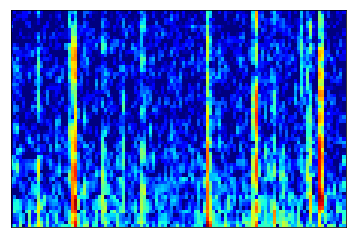

In [0]:
########## Przykład jak ładować dane
nazwa = nazwa_list[i]
nazwa_out = '_7rep'
#dane1 = np.load(source_out + nazwa + 'balanced_dataset.npy')
dane1 = np.load(source_out + nazwa + nazwa_out + '.npz' )
#fre = opisy1['freqs']
#print(opisy1.files)
#print(fre)

r3 = dane1['rep3']
des = dane1['final_description']
print('Nagranie ' + str(nazwa))
print('Dostepne dane: ' + str(dane1.files))
print('Rozmiar reprezentacji 3: ' + str(np.shape(dane1["rep2"])))
k = 49 # nr próbki
print(des[k])
librosa.display.specshow(r3[k], cmap="jet", sr=44100)

print('Labele opisu przykładowej probki nr ' + str(k) + ":"+ str(dane1['labels']))
print('Opis probki nr ' + str(k) + ":"+ str(des[k]))
print('Ilośc próbek z tego nagrania: '+ str(np.shape(dane1['final_description'])[0]))
print('Jest ptak w tym przykładowym? '+ str(des[k][7]))


#print(dane1['spec'])